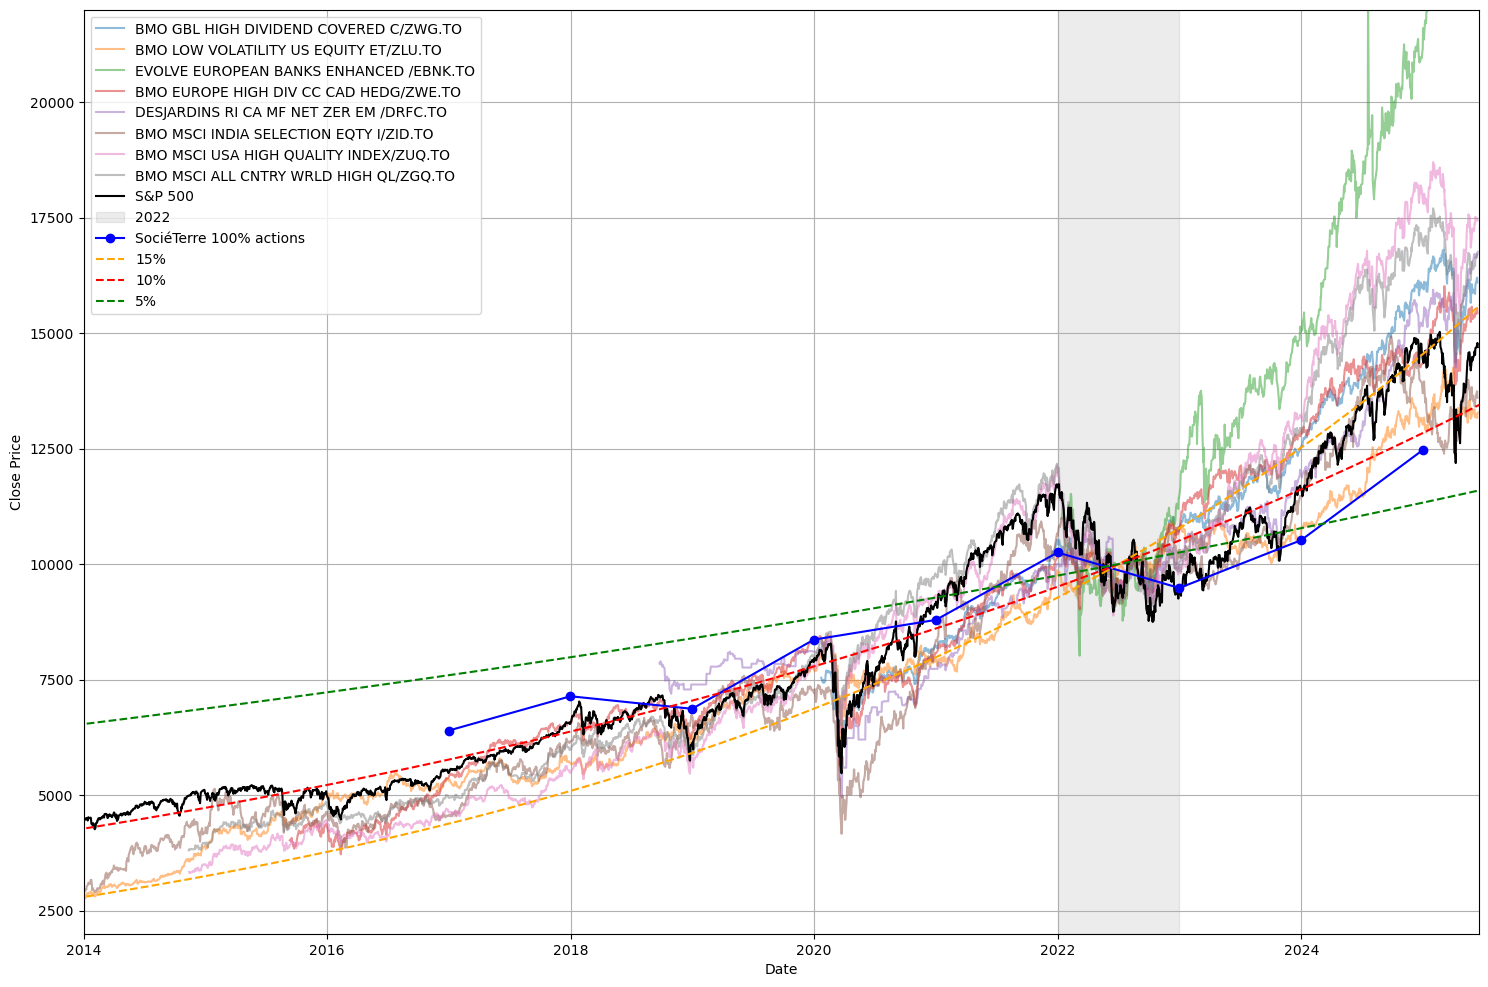

21:39:49.295 |  Annualized returns:
21:39:49.295 |  Mean slope: 15.118% per year
21:39:49.296 |  ZWG.TO: 15.599% per year
21:39:49.297 |  ZLU.TO: 12.072% per year
21:39:49.297 |  EBNK.TO: 32.284% per year
21:39:49.298 |  ZWE.TO: 12.844% per year
21:39:49.299 |  DRFC.TO: 11.949% per year
21:39:49.300 |  ZID.TO: 11.940% per year
21:39:49.300 |  ZUQ.TO: 15.271% per year
21:39:49.301 |  ZGQ.TO: 13.674% per year
21:39:49.301 |  ^SPX: 10.428% per year
21:39:49.302 |  S&P 500: 10.428% per year
21:39:49.302 |  SociéTerre: 9.311% per year


In [6]:
import bydoux_tools as bt
import numpy as np
import matplotlib.pyplot as plt
from astropy.table import Table
from astropy.time import Time
import matplotlib.cm as cm

# List of tickers to analyze (Canadian and US ETFs + S&P 500 index)
tickers = ['ZWG.TO','ZLU.TO','EBNK.TO','ZWE.TO','DRFC.TO','ZID.TO','ZUQ.TO','ZGQ.TO','^SPX']

# Define a color palette for plotting (tab10, one color per ticker except ^SPX)
# Use the new recommended API for colormaps in matplotlib >=3.7
palette = plt.colormaps['tab10']  # or plt.colormaps.get_cmap('tab10')
# Assign a unique color to each ticker, but force ^SPX to be black for clarity
colors = {ticker: palette(i) for i, ticker in enumerate(tickers) if ticker != '^SPX'}
colors['^SPX'] = 'black'

# Define time intervals for analysis
t0 = Time('2014-01-01', format='iso')      # Start of main analysis window
t1 = Time('2022-01-01', format='iso')      # Start of shaded region (2022)
t2 = Time('2022-12-31', format='iso')      # End of shaded region (2022)

# SociéTerre reference data: annual returns for benchmarking
#yr_societerre = [2024, 2023, 2022, 2021, 2020]  # Years for SociéTerre
#rate = [16.09, 10.15, -16.12, 12.94, 18.16]     # Annual returns in percent

yr_societerre = [2024, 2023, 2022, 2021, 2020, 2019, 2018, 2017, 2016]  # Years for SociéTerre
rate = [18.6, 10.9, -7.5, 16.6, 5.1, 21.8, -3.8, 11.6, 10.5]

rate = np.array(rate) / 100                     # Convert percent to fraction for plotting

# Sort SociéTerre data by year (ascending)
ord = np.argsort(yr_societerre)
rate = rate[ord]
yr_societerre = np.array(yr_societerre)[ord]

# Compute cumulative product to simulate portfolio growth (starting at 1)
val_societerre =  np.cumprod(1 + rate)
# Normalize to value at 2022 and scale to 10,000 for comparison
val_societerre = val_societerre / np.mean(val_societerre[np.abs(yr_societerre -2022.5)<1]) * 10000
# Convert SociéTerre years to datetime for plotting
yr_societerre = [Time(f'{yr}-12-31', format='iso').datetime for yr in yr_societerre]

# Prepare to store annualized slopes for each ticker
slopes = []

# Create a large figure and axis for plotting
fig, ax = plt.subplots(figsize=(18, 12))

# Loop over each ticker and plot its normalized price evolution
for ticker in tickers:
    # Read historical quotes for the ticker
    tbl = bt.read_quotes(ticker)
    # Get info dictionary for the ticker (for display name)
    info = bt.get_info(ticker)
    if 'shortName' in info:
        short_name = info['shortName']+'/'+ticker
    else:
        short_name = ticker

    # Convert MJD dates to datetime for plotting
    tbl['time_plot'] = Time(tbl['mjd'], format='mjd').datetime

    # Find dates between 2022-01-01 and 2022-12-31 for normalization
    g = (tbl['time_plot'] >= t1.datetime) & (tbl['time_plot'] <= t2.datetime)
    # Center log_close values on the 2022 period for fair comparison
    tbl['log_close'] -= np.mean(tbl['log_close'][g])

    # Only use data from t0 onward for slope calculation
    g2 = tbl['time_plot'] >= t0.datetime

    # Fit a linear trend (slope) to log_close vs. time (in MJD) for annualized return
    slope = np.polyfit(tbl['mjd'][g2], tbl['log_close'][g2], 1)
    slopes.append((ticker, slope[0]* 365.24))    # Store for summary

    # Set plot style: S&P 500 is opaque and labeled, others are semi-transparent
    if ticker == '^SPX':
        alpha = 1.0
        label = 'S&P 500'
    else:
        alpha = 0.5
        label = short_name

    # Plot the normalized price evolution (exponentiate log_close, scale to 10,000)
    plt.plot(
        tbl['time_plot'],
        np.exp(tbl['log_close'])*10000,
        label=label,
        alpha=alpha,
        color=colors[ticker]
    )

# Highlight the year 2022 with a shaded region for visual reference
ax.axvspan(
    t1.datetime,
    t2.datetime,
    color='grey',
    alpha=0.15,
    label='2022'
)

# Create a time vector from 2010 to 2026 for plotting reference growth lines
time_vector = np.linspace(Time('2010-01-01').mjd, Time('2026-01-01').mjd, 100)
# Center the time vector on the middle of 2022 for reference lines
dt = (time_vector - (t1.mjd+t2.mjd)/2)/365.24

# Plot SociéTerre reference portfolio as blue dots
ax.plot(yr_societerre, val_societerre, label='SociéTerre 100% actions', color='blue', marker='o')

# Plot reference exponential growth lines for 15% and 10% annual returns
ax.plot(Time(time_vector, format='mjd').datetime,  np.exp(0.15*dt) * 10000, label='15%', color='orange', linestyle='--')
ax.plot(Time(time_vector, format='mjd').datetime,  np.exp(0.10*dt) * 10000, label='10%', color='red', linestyle='--')
ax.plot(Time(time_vector, format='mjd').datetime,  np.exp(0.05*dt) * 10000, label='5%', color='green', linestyle='--')

# Set x-axis limits from 2019 to today
ax.set_xlim(Time('2014-01-01').datetime, Time.now().datetime)
ax.set_xlabel('Date')         # Label x-axis
ax.set_ylabel('Close Price')  # Label y-axis
ax.legend()                   # Show legend
ax.set_ylim(2000,22000)       # Set y-axis limits for clarity
ax.grid(True)                # Enable grid for better readability
# Save the figure as a high-resolution PDF
fig.savefig('prospective_plot.pdf', dpi=600)
plt.show()

# Print summary statistics for annualized returns
bt.printc('Annualized returns:')
bt.printc(f'Mean slope: {np.nanmean([s[1] for s in slopes])*100:.3f}% per year')

for ticker, slope in slopes:
    bt.printc(f'{ticker}: {slope*100:.3f}% per year')

bt.printc('S&P 500: {:.3f}% per year'.format(slopes[-1][1]*100))
bt.printc(f'SociéTerre: {np.mean(rate)*100:.3f}% per year')